# Generate simulation data

In [383]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
#from iterated_blocking import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox


%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))

In [274]:
bonds32 = Bonds(32, run=True, num_steps=1E7)

compilation -- start

compilation -- done

runs -- start

Running T = 1.0
Running T = 1.1
Running T = 1.2
Running T = 1.3
Running T = 1.4
Running T = 1.5
Running T = 1.6
Running T = 1.7
Running T = 1.8
Running T = 1.9
Running T = 2.0
Running T = 2.1
Running T = 2.2
Running T = 2.3
Running T = 2.4
Running T = 2.5
Running T = 2.6
Running T = 2.7
Running T = 2.8
Running T = 2.9
Running T = 3.0
Running T = 3.1
Running T = 3.2
Running T = 3.3
Running T = 3.4


In [313]:
#for i in range(10):
bonds4 = Bonds(4, run=True, num_steps=1E7)
bonds8 = Bonds(8, run=True, num_steps=1E7)
bonds16 = Bonds(16, run=True, num_steps=1E7)
bonds32 = Bonds(32, run=True, num_steps=1E7)

compilation -- start

compilation -- done

runs -- start

Running T = 1.0
Running T = 1.1
Running T = 1.2
Running T = 1.3
Running T = 1.4
Running T = 1.5
Running T = 1.6
Running T = 1.7
Running T = 1.8
Running T = 1.9
Running T = 2.0
Running T = 2.1
Running T = 2.2
Running T = 2.3
Running T = 2.4
Running T = 2.5
Running T = 2.6
Running T = 2.7
Running T = 2.8
Running T = 2.9
Running T = 3.0
Running T = 3.1
Running T = 3.2
Running T = 3.3
Running T = 3.4
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.8.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.9.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.9.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.8.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_3.3.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_1.6.txt
Saving configs to: ../data/configs/4_lattice/separated_data/4_config_2.7.txt
Sav

Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.4.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.5.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.0.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_3.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.7.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.6.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.2.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.3.txt
Saving blocked configs to: ../data/blocked_configs/8_lattice/double_bo

Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.8.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.9.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.9.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.8.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_3.3.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.6.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.7.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.5.txt
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/32_co

In [317]:
bonds32 = Bonds(32, run=True, num_steps=1E8)

compilation -- start

compilation -- done

runs -- start

Running T = 1.0
Running T = 1.1
Running T = 1.2
Running T = 1.3
Running T = 1.4
Running T = 1.5
Running T = 1.6
Running T = 1.7
Running T = 1.8
Running T = 1.9
Running T = 2.0
Running T = 2.1
Running T = 2.2
Running T = 2.3
Running T = 2.4
Running T = 2.5
Running T = 2.6
Running T = 2.7
Running T = 2.8
Running T = 2.9
Running T = 3.0
Running T = 3.1
Running T = 3.2
Running T = 3.3
Running T = 3.4
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_2.9.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_3.3.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_config_1.6.txt
Saving configs to: ../data/configs/32_lattice/separated_data/32_conf

## $\langle N_b \rangle$, and $\langle \Delta_{N_b}^2\rangle$

In [390]:
bc32 = bond_counter(32, write=True)
bc32_b = bond_counter(32, blocked_val=0, write=True)

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt

Writing to: ../data/bond_counts/32_lattice/num_bonds_32.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt

Writing to: ../data/bond_counts/32_lattice/num_bonds_32.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt

Writing to: ../data/bond_counts/32_lattice/num_bonds_32.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt

Writing to: ../data/bond_counts/32_lattice/num_bonds_32.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt

Writing to: ../data/bond_counts/32_lattice/num_bonds_32.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt

Writing to: ../data/bond_counts/32_lattice/num_bonds_32.txt

Reading from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt

Writing to: ../data/bond_counts/32_lattice/num_bonds_32.txt

Reading from: ../data/configs/32_lattice/separat

In [392]:
bc16 = bond_counter(16, write=True)
bc16_b = bond_counter(16, blocked_val=0, write=True)

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.0.txt

Writing to: ../data/bond_counts/16_lattice/num_bonds_16.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.1.txt

Writing to: ../data/bond_counts/16_lattice/num_bonds_16.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.2.txt

Writing to: ../data/bond_counts/16_lattice/num_bonds_16.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.3.txt

Writing to: ../data/bond_counts/16_lattice/num_bonds_16.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.4.txt

Writing to: ../data/bond_counts/16_lattice/num_bonds_16.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.5.txt

Writing to: ../data/bond_counts/16_lattice/num_bonds_16.txt

Reading from: ../data/configs/16_lattice/separated_data/16_config_1.6.txt

Writing to: ../data/bond_counts/16_lattice/num_bonds_16.txt

Reading from: ../data/configs/16_lattice/separat

In [393]:
bc8 = bond_counter(8, write=True)
bc8_b = bond_counter(8, blocked_val=0, write=True)

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt

Writing to: ../data/bond_counts/8_lattice/num_bonds_8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt

Writing to: ../data/bond_counts/8_lattice/num_bonds_8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt

Writing to: ../data/bond_counts/8_lattice/num_bonds_8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt

Writing to: ../data/bond_counts/8_lattice/num_bonds_8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.4.txt

Writing to: ../data/bond_counts/8_lattice/num_bonds_8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.5.txt

Writing to: ../data/bond_counts/8_lattice/num_bonds_8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt

Writing to: ../data/bond_counts/8_lattice/num_bonds_8.txt

Reading from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt

Wri

In [394]:
bc4 = bond_counter(4, write=True)
bc4_b = bond_counter(4, blocked_val=0, write=True)

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt

Writing to: ../data/bond_counts/4_lattice/num_bonds_4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt

Writing to: ../data/bond_counts/4_lattice/num_bonds_4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt

Writing to: ../data/bond_counts/4_lattice/num_bonds_4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt

Writing to: ../data/bond_counts/4_lattice/num_bonds_4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt

Writing to: ../data/bond_counts/4_lattice/num_bonds_4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt

Writing to: ../data/bond_counts/4_lattice/num_bonds_4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt

Writing to: ../data/bond_counts/4_lattice/num_bonds_4.txt

Reading from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt

Wri

In [400]:
temps32 = np.array([float(i) for i in list(bc32.keys())])
flucts32 = np.array([i[3] for i in list(bc32.values())])
temps16 = np.array([float(i) for i in list(bc16.keys())])
flucts16 = np.array([i[3] for i in list(bc16.values())])
temps8 = np.array([float(i) for i in list(bc8.keys())])
flucts8 = np.array([i[3] for i in list(bc8.values())])
temps4 = np.array([float(i) for i in list(bc4.keys())])
flucts4 = np.array([i[3] for i in list(bc4.values())])

In [404]:
temps32_b = np.array([float(i) for i in list(bc32_b.keys())])
flucts32_b = np.array([i[3] for i in list(bc32_b.values())])
temps16_b = np.array([float(i) for i in list(bc16_b.keys())])
flucts16_b = np.array([i[3] for i in list(bc16_b.values())])
temps8_b = np.array([float(i) for i in list(bc8_b.keys())])
flucts8_b = np.array([i[3] for i in list(bc8_b.values())])
temps4_b = np.array([float(i) for i in list(bc4_b.keys())])
flucts4_b = np.array([i[3] for i in list(bc4_b.values())])

<IPython.core.display.Javascript object>


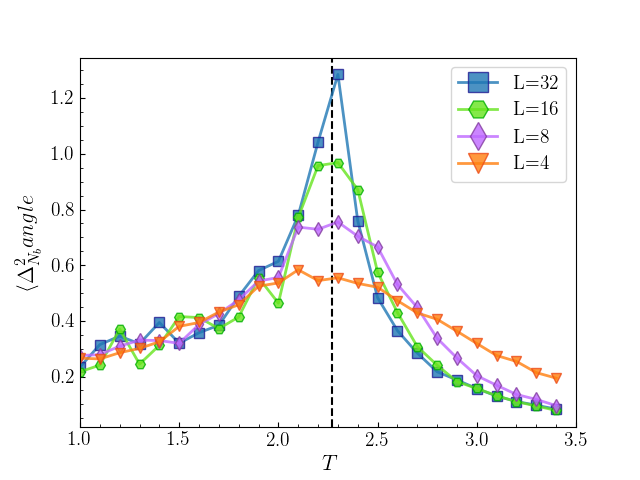

In [406]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(temps32, flucts32/(2*32*32),
        marker='s', color='C0',
        markersize=7,  markeredgecolor='#1f1b93',
        ls='-', fillstyle='full', lw=2,
        alpha=0.8,
        label='L=32')
            
ax.plot(temps16, flucts16/(2*16*16),
        marker='H', color='#65e41d',
        markeredgecolor='#00B000', markersize=7., 
        lw=2, alpha=0.8, ls='-',
        fillstyle='full',
        label='L=16')

ax.plot(temps8, flucts8/(2*8*8),
        marker='d', fillstyle='full', color='#be67ff',
        markeredgecolor='#833c9f', markersize=7, 
        lw=2, alpha=0.8, ls='-',
        label='L=8')


ax.plot(temps4, flucts4/(2*4*4),
        color='C1', markeredgecolor='#ed4c18', marker='v', 
        fillstyle='full', markersize=7,  lw=2, 
        alpha=0.8, ls='-',
        label='L=4')


ax.legend(loc='best', markerscale=2, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\langle \Delta_{N_b}^2\rangle$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


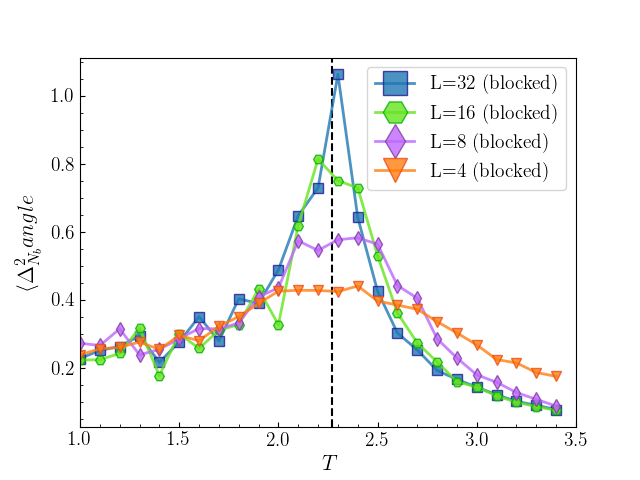

In [405]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(temps32_b, flucts32_b/(2*16*16),
        marker='s', color='C0',
        markersize=7,  markeredgecolor='#1f1b93',
        ls='-', fillstyle='full', lw=2,
        alpha=0.8,
        label='L=32 (blocked)')
            
ax.plot(temps16_b, flucts16_b/(2*8*8),
        marker='H', color='#65e41d',
        markeredgecolor='#00B000', markersize=7., 
        lw=2, alpha=0.8, ls='-',
        fillstyle='full',
        label='L=16 (blocked)')

ax.plot(temps8_b, flucts8_b/(2*4*4),
        marker='d', fillstyle='full', color='#be67ff',
        markeredgecolor='#833c9f', markersize=7, 
        lw=2, alpha=0.8, ls='-',
        label='L=8 (blocked)')


ax.plot(temps4_b, flucts4_b/(2*2*2),
        color='C1', markeredgecolor='#ed4c18', marker='v', 
        fillstyle='full', markersize=7,  lw=2, 
        alpha=0.8, ls='-',
        label='L=4 (blocked)')


ax.legend(loc='best', markerscale=2, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\langle \Delta_{N_b}^2\rangle$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


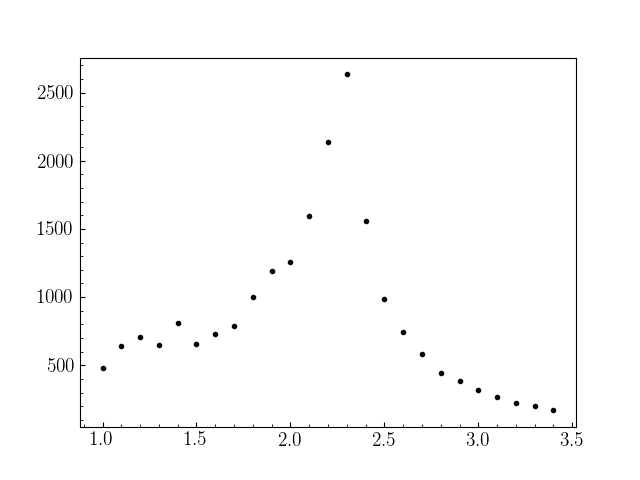

In [395]:
fig, ax = plt.subplots()
ax.plot(temps32, flucts32)
plt.show()

<IPython.core.display.Javascript object>


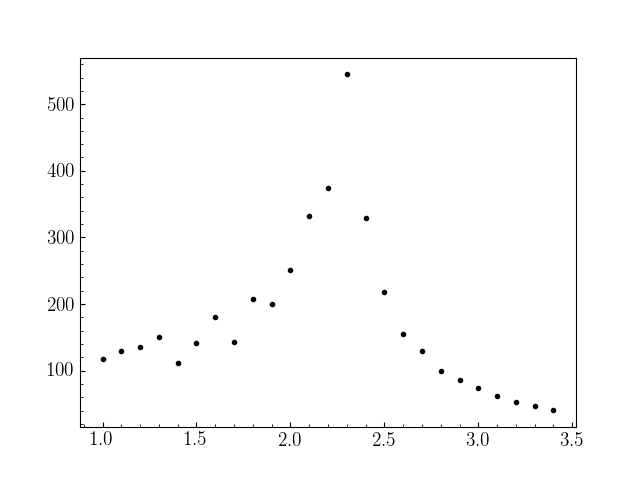

In [396]:
temps32_b = [float(i) for i in list(bc32_b.keys())]
flucts32_b = [i[3] for i in list(bc32_b.values())]
fig, ax = plt.subplots()
ax.plot(temps32_b, flucts32_b, 'k.')
plt.show()

## Principal Component Analysis

In [367]:
pca32 = PrincipalComponent(32)

Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.0.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.1.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.2.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.3.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.4.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.5.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.6.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.7.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.8.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_1.9.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.0.txt
Reading data from: ../data/configs/32_lattice/separated_data/32_config_2.1.txt
Reading data from: ../data/configs/32_lattice/separa

In [373]:
pca32_b = PrincipalComponent(32, blocked_val=0)

Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.0.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.1.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.2.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.3.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.4.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.5.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.6.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.7.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.8.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_1.9.txt
Reading data from: ../data/blocked_configs/32_lattice/double_bonds_0/32_config_2.0.txt
Reading data from: ../data/blocked_configs/

In [374]:
pca16 = PrincipalComponent(16)

Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.0.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.1.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.2.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.3.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.4.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.5.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.6.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.7.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.8.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_1.9.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.0.txt
Reading data from: ../data/configs/16_lattice/separated_data/16_config_2.1.txt
Reading data from: ../data/configs/16_lattice/separa

In [378]:
pca16_b = PrincipalComponent(16, blocked_val=0)

Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.0.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.1.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.2.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.3.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.4.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.5.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.6.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.7.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.8.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_1.9.txt
Reading data from: ../data/blocked_configs/16_lattice/double_bonds_0/16_config_2.0.txt
Reading data from: ../data/blocked_configs/

In [375]:
pca8 = PrincipalComponent(8)

Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.0.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.1.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.2.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.3.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.4.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.5.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.6.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.7.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.8.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_1.9.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.0.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.1.txt
Reading data from: ../data/configs/8_lattice/separated_data/8_config_2.2.txt

In [376]:
pca8_b = PrincipalComponent(8, blocked_val=0)

Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.0.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.1.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.2.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.3.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.4.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.5.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.6.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.7.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.8.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_1.9.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds_0/8_config_2.0.txt
Reading data from: ../data/blocked_configs/8_lattice/double_bonds

In [377]:
pca4 = PrincipalComponent(4)

Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.0.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.1.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.2.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.3.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.4.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.5.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.6.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.7.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.8.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_1.9.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.0.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.1.txt
Reading data from: ../data/configs/4_lattice/separated_data/4_config_2.2.txt

In [379]:
pca4_b = PrincipalComponent(4, blocked_val=0)

Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.0.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.1.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.2.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.3.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.4.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.5.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.6.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.7.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.8.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_1.9.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds_0/4_config_2.0.txt
Reading data from: ../data/blocked_configs/4_lattice/double_bonds

<IPython.core.display.Javascript object>


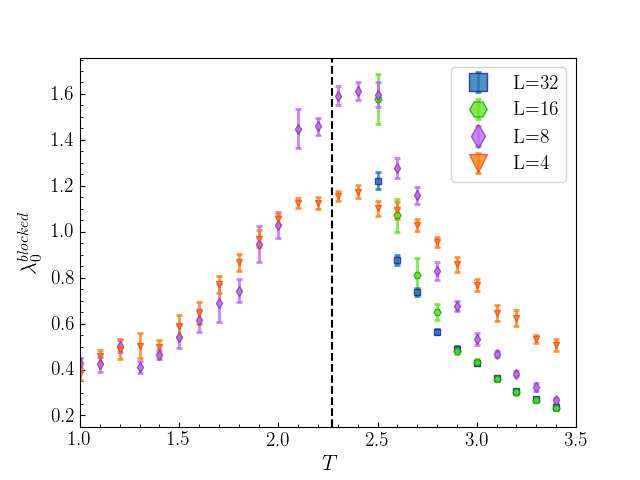

In [380]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32_b._temps, pca32_b._leading_eig_val_avg,
            yerr=list(pca32_b._err.values()),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=1.,
            elinewidth=2.,  alpha=0.8,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16_b._temps, pca16_b._leading_eig_val_avg,
            yerr=list(pca16_b._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(pca8_b._temps, pca8_b._leading_eig_val_avg,
            yerr=list(pca8_b._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.errorbar(pca4_b._temps, pca4_b._leading_eig_val_avg,
            yerr=list(pca4_b._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, elinewidth=2., 
            alpha=0.8, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_0^{blocked}$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


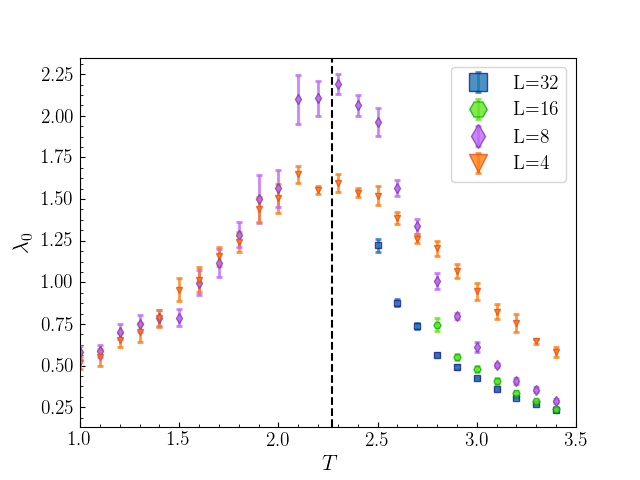

In [381]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32._temps, pca32._leading_eig_val_avg,
            yerr=list(pca32._err.values()),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=1.,
            elinewidth=2.,  alpha=0.8,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16._temps, pca16._leading_eig_val_avg,
            yerr=list(pca16._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

ax.errorbar(pca8._temps, pca8._leading_eig_val_avg,
            yerr=list(pca8._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.errorbar(pca4._temps, pca4._leading_eig_val_avg,
            yerr=list(pca4._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, elinewidth=2., 
            alpha=0.8, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_0$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

## Specific Heat

In [326]:
specific_heat32 = SpecificHeat(32)
specific_heat16 = SpecificHeat(16)
specific_heat8 = SpecificHeat(8)
specific_heat4 = SpecificHeat(4)

<IPython.core.display.Javascript object>


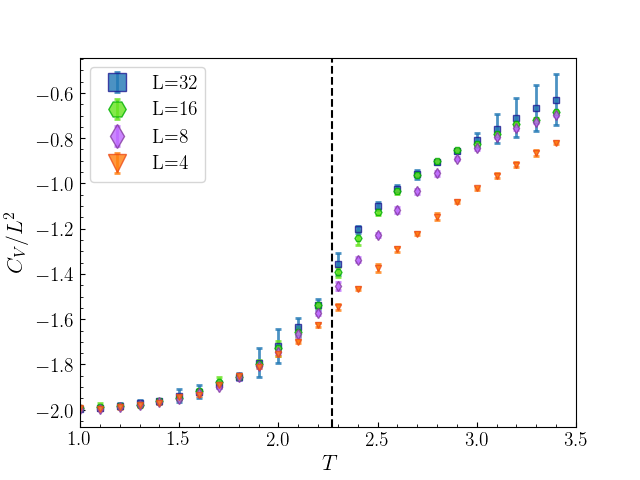

In [327]:
fig, ax = plt.subplots()
ax.errorbar(specific_heat32._energy_temps, specific_heat32._avg_energy,
            yerr=specific_heat32._energy_error,
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='', fillstyle='full', lw=1.,
            elinewidth=2.,  alpha=0.8,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(specific_heat16._energy_temps, specific_heat16._avg_energy,
            yerr=specific_heat16._energy_error,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')

#ax.plot(t8, spec_heat8._Cv_arr, marker='.', ls='', markersize=5, mew=0.4, color='C0')
ax.errorbar(specific_heat8._energy_temps, specific_heat8._avg_energy,
            yerr=specific_heat8._energy_error,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., elinewidth=2.,  alpha=0.8, ls='',
            capsize=2, capthick=2, 
            label='L=8')


ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
#ax.plot(t4, spec_heat4._Cv_arr, marker='.', ls='', markersize=5, mew=0.4, color='C0')
ax.errorbar(specific_heat4._energy_temps, specific_heat4._avg_energy,
            yerr=specific_heat4._energy_error,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, elinewidth=2., 
            alpha=0.8, capsize=2, capthick=2,  ls='',
            label='L=4')

ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$C_V/L^2$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

plt.show()

<IPython.core.display.Javascript object>


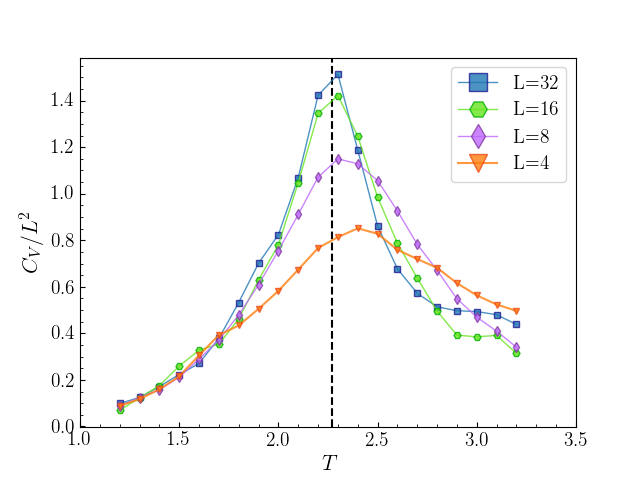

In [328]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.plot(specific_heat32._specific_heat_temps, specific_heat32._specific_heat,
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=1.,
            alpha=0.8,
            label='L=32')
            
ax.plot(specific_heat16._specific_heat_temps, specific_heat16._specific_heat,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=1., alpha=0.8, ls='-',
            fillstyle='full',
            label='L=16')

ax.plot(specific_heat8._specific_heat_temps, specific_heat8._specific_heat,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=1., alpha=0.8, ls='-',
            label='L=8')


ax.plot(specific_heat4._specific_heat_temps, specific_heat4._specific_heat,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=1.5, 
            alpha=0.8, ls='-',
            label='L=4')


ax.legend(loc='best', markerscale=2.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$C_V/L^2$', fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
plt.show()

plt.show()

## Plot Configs

<IPython.core.display.Javascript object>


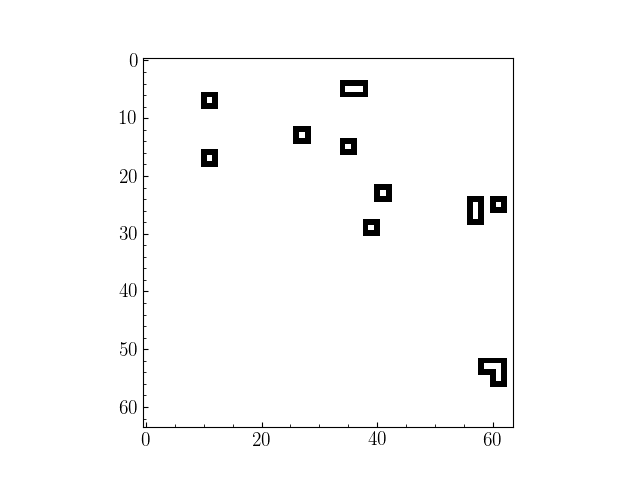

In [289]:
fig, ax = plt.subplots()
ax.imshow(bonds32._config_data['3.'][5], cmap='Greys')
plt.show()

## OLD

In [47]:
bonds_dict = bonds32._get_bonds()

In [76]:
mapped_bonds = {}
for temp, bond_dict in bonds_dict.items():
    #bb = np.zeros((len(list(bonds_dict['1.'].keys())), len(list(bonds_dict['1.'][0]))))
    #_mapped_bonds = {}
    num_configs = len(bond_dict)
    bond_sites = []
    for key, val in bond_dict.items():
        _bond_sites = []
        for i in range(num_configs):
            _bond_sites.append([bonds32._map[key], np.array(val[])])
        #for i in range(len(val)):
        #    _bond_sites.append((bonds32._map[val[i,0]], val[i, 1]))
        #try:
        #    _mapped_bonds[key].append(_bond_sites)
        #except KeyError:
        #    _mapped_bonds[key] = [_bond_sites]
    #mapped_bonds[temp] = _mapped_bonds
    mapped_bonds[temp] = np.array(bond_sites)

TypeError: list indices must be integers or slices, not tuple

In [227]:
bonds32._mapped_bonds['3.1'][2][0]

[(2, 0), (1, 0)]

In [200]:
bonds32._mapped_bonds['3.1'][0][1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [220]:
configs_active_bonds = {}
active_bonds = {}
for key, val in bonds32._mapped_bonds.items():
    active_bonds[key] = []
    #_configs_active_bonds = {}
    #_configs_active_bonds
    configs_active_bonds[key] = {}
    for i in val:
        for jdx, j in enumerate(i[1]):
            configs_active_bonds[key][jdx] = []
            if j % 2 == 1:
                active_bonds[key].append(i[0])
                configs_active_bonds[key][jdx] = np.unique(active_bonds[key])
            #configs_active_bonds[key][jdx] = active_bonds[key]
                
        #config_idxs = np.where(i[1] % 2 == 1)
        #active_bonds[key].append(i[0])
    #_configs_active_bonds[key] = active_bonds[key]
        #for idx in config_idxs[0]:
        #    configs_active_bonds[key] = {idx: active_bonds[key]} #_configs_active_bonds[key]
            #try:
            #    configs_active_bonds[idx].append(active_bonds[key].append(i[0]))
            #except KeyError:
            #    configs_active_bonds[idx] = [active_bonds[key].append(i[0])]
        #active_bonds[key].append([i[0], config_idxs])

KeyboardInterrupt: 

In [212]:
configs_active_bonds.keys()

dict_keys(['2.8', '1.9', '2.9', '1.8', '3.3', '1.6', '2.7', '2.5', '1.4', '3.1', '1.', '2.1', '2.3', '1.2', '2.4', '1.5', '3.', '3.2', '1.7', '2.6', '2.2', '1.3', '3.4', '1.1', '2.'])

In [219]:
configs_active_bonds['1.'][0]

[[(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)],
 [(31, 31), (31, 0)]]

In [197]:
len(configs_active_bonds['3.1'][29])

2048

In [190]:
for key, val in configs_active_bonds.items():
    print("{} {}".format(key, val.keys()))

2.8 dict_keys([50])
1.9 dict_keys([80])
2.9 dict_keys([54])
1.8 dict_keys([80])
3.3 dict_keys([49])
1.6 dict_keys([74])
2.7 dict_keys([80])
2.5 dict_keys([73])
1.4 dict_keys([74])
3.1 dict_keys([29])
1. dict_keys([80])
2.1 dict_keys([78])
2.3 dict_keys([71])
1.2 dict_keys([77])
2.4 dict_keys([64])
1.5 dict_keys([80])
3. dict_keys([70])
3.2 dict_keys([71])
1.7 dict_keys([78])
2.6 dict_keys([62])
2.2 dict_keys([78])
1.3 dict_keys([76])
3.4 dict_keys([9])
1.1 dict_keys([79])
2. dict_keys([80])


In [130]:
x_bonds = {}
y_bonds = {}
x_bonds_pairs = {}
y_bonds_pairs = {}
configs_x_bonds = {}
for key, val in active_bonds.items():
    x_sites = []
    y_sites = []
    configs = [i[1] for i in val]
    sites = [i[0] for i in val]
    x_configs_sites_idxs = []
    y_configs_sites_idxs = []
    for idx, site in enumerate(sites):
        start_site = np.array(site[0])
        end_site = np.array(site[1])
        diff = abs(start_site - end_site)
        if diff[0] in [1, bonds32._L - 1]:
            x_sites.append(sorted(tuple(site)))
            x_configs_sites_idxs.append(configs[idx])
        elif diff[1] in [1, bonds32._L - 1]:
            y_sites.append(sorted(tuple(site)))
            y_configs_sites_idxs.append(configs[idx])
    x_bonds[key] = [np.array(x_sites, dtype=int).tolist(), x_configs_sites_idxs]
    y_bonds[key] = [np.array(y_sites, dtype=int).tolist(), y_configs_sites_idxs]
    for i in range(len(x_bonds[key][0])):
        try:
            x_bonds_pairs[key].append([x_bonds[key][0][i], x_bonds[key][1][i][0]])
        except KeyError:
            x_bonds_pairs[key] = [x_bonds[key][0][i], x_bonds[key][1][i][0]]
    for i in range(len(y_bonds[key][0])):
        try:
            y_bonds_pairs[key].append([y_bonds[key][0][i], y_bonds[key][1][i][0]])
        except KeyError:
            y_bonds_pairs[key] = [y_bonds[key][0][i], y_bonds[key][1][i][0]]
    
    

In [128]:
q = []
for i in range(len(x_bonds['3.1'][0])):
    q.append([x_bonds['3.1'][0][i], x_bonds['3.1'][1][i][0]])
#x_bonds['3.1'][0][:], x_bonds['3.1'][1][:])

In [144]:
bonds32._active_bonds['1.']

[[[(1, 0), (0, 0)],
  (array([ 1,  2,  3,  4,  5,  7,  8, 10, 11, 12, 13, 15, 17, 22, 24, 27, 29,
          30, 31, 32, 34, 37, 40, 41, 43, 46, 50, 54, 55, 56, 59, 61, 65, 67,
          69, 71, 73, 75, 78]),)],
 [[(0, 1), (0, 0)],
  (array([ 3,  5,  6,  8, 13, 15, 16, 18, 21, 22, 23, 24, 26, 27, 30, 31, 33,
          34, 36, 37, 40, 44, 46, 49, 51, 52, 54, 60, 61, 63, 64, 65, 66, 67,
          70, 71, 76, 79, 80]),)],
 [[(2, 0), (1, 0)],
  (array([ 0,  2,  4,  5,  7,  9, 10, 12, 15, 16, 18, 19, 20, 23, 24, 25, 26,
          30, 33, 35, 37, 38, 39, 42, 46, 48, 50, 53, 55, 56, 57, 58, 60, 61,
          62, 63, 64, 65, 70, 71, 72, 78]),)],
 [[(1, 1), (1, 0)],
  (array([ 1,  5,  7,  9, 13, 15, 16, 17, 18, 21, 23, 25, 28, 30, 33, 39, 40,
          44, 46, 48, 49, 52, 53, 54, 59, 60, 64, 65, 67, 69, 70, 71, 72, 80]),)],
 [[(3, 0), (2, 0)],
  (array([ 0,  1,  2,  4,  7,  8, 10, 15, 18, 20, 21, 24, 25, 28, 29, 30, 31,
          32, 34, 37, 41, 42, 49, 51, 55, 57, 62, 63, 64, 65, 66, 67, 71, 73

In [152]:
bonds32._active_x_bonds['3.1'][1][0]

(array([25, 29, 32, 37]),)

In [147]:
mapped_arr_31 = bonds32._set_config_data(3.1)

In [149]:
mapped_arr_31.shape

(64, 64)

<IPython.core.display.Javascript object>


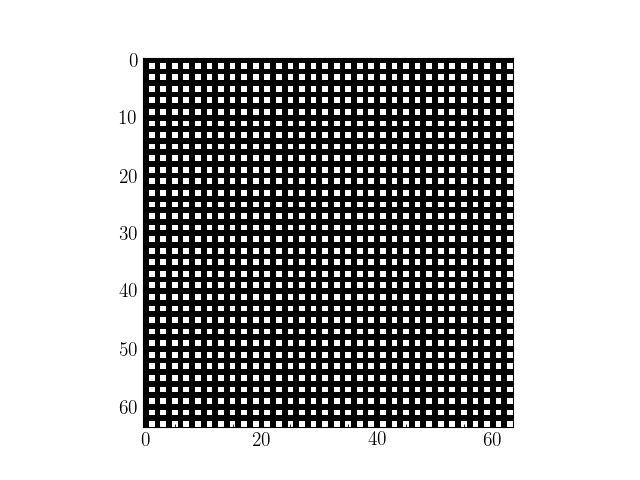

In [150]:
fig, ax = plt.subplots()
ax.imshow(mapped_arr_31, cmap='Greys')
plt.show()

In [4]:
for i in range(10):
    bonds4 = Bonds(4, run=True, num_steps=1E5, T_step=0.02)
    bonds8 = Bonds(8, run=True, num_steps=1E6, T_step=0.02)
    bonds16 = Bonds(16, run=True, T_step=0.02)
    bonds32 = Bonds(32, run=True, T_step=0.02)

compilation -- start

compilation -- done

runs -- start

Running T = 1.0
Running T = 1.02
Running T = 1.04
Running T = 1.06
Running T = 1.08
Running T = 1.1
Running T = 1.12
Running T = 1.14
Running T = 1.16
Running T = 1.18
Running T = 1.2
Running T = 1.22
Running T = 1.24
Running T = 1.26
Running T = 1.28
Running T = 1.3
Running T = 1.32
Running T = 1.34
Running T = 1.36
Running T = 1.38
Running T = 1.4
Running T = 1.42
Running T = 1.44
Running T = 1.46
Running T = 1.48
Running T = 1.5
Running T = 1.52
Running T = 1.54
Running T = 1.56
Running T = 1.58
Running T = 1.6
Running T = 1.62
Running T = 1.64
Running T = 1.66
Running T = 1.68
Running T = 1.7
Running T = 1.72
Running T = 1.74
Running T = 1.76
Running T = 1.78
Running T = 1.8
Running T = 1.82
Running T = 1.84
Running T = 1.86
Running T = 1.88
Running T = 1.9
Running T = 1.92
Running T = 1.94
Running T = 1.96
Running T = 1.98
Running T = 2.0
Running T = 2.02
Running T = 2.04
Running T = 2.06
Running T = 2.08
Running T = 2.1
Ru

Running T = 2.5
Running T = 2.52
Running T = 2.54
Running T = 2.56
Running T = 2.58
Running T = 2.6
Running T = 2.62
Running T = 2.64
Running T = 2.66
Running T = 2.68
Running T = 2.7
Running T = 2.72
Running T = 2.74
Running T = 2.76
Running T = 2.78
Running T = 2.8
Running T = 2.82
Running T = 2.84
Running T = 2.86
Running T = 2.88
Running T = 2.9
Running T = 2.92
Running T = 2.94
Running T = 2.96
Running T = 2.98
Running T = 3.0
Running T = 3.02
Running T = 3.04
Running T = 3.06
Running T = 3.08
Running T = 3.1
Running T = 3.12
Running T = 3.14
Running T = 3.16
Running T = 3.18
Running T = 3.2
Running T = 3.22
Running T = 3.24
Running T = 3.26
Running T = 3.28
Running T = 3.3
Running T = 3.32
Running T = 3.34
Running T = 3.36
Running T = 3.38
Running T = 3.4
Running T = 3.42
Running T = 3.44
Running T = 3.46
Running T = 3.48
Saving configs to: ../data/configs/32_lattice/separated_data/
Saving blocked configs to: ../data/blocked_configs/32_lattice/double_bonds_0/
compilation -- start

Running T = 1.32
Running T = 1.34
Running T = 1.36
Running T = 1.38
Running T = 1.4
Running T = 1.42
Running T = 1.44
Running T = 1.46
Running T = 1.48
Running T = 1.5
Running T = 1.52
Running T = 1.54
Running T = 1.56
Running T = 1.58
Running T = 1.6
Running T = 1.62
Running T = 1.64
Running T = 1.66
Running T = 1.68
Running T = 1.7
Running T = 1.72
Running T = 1.74
Running T = 1.76
Running T = 1.78
Running T = 1.8
Running T = 1.82
Running T = 1.84
Running T = 1.86
Running T = 1.88
Running T = 1.9
Running T = 1.92
Running T = 1.94
Running T = 1.96
Running T = 1.98
Running T = 2.0
Running T = 2.02
Running T = 2.04
Running T = 2.06
Running T = 2.08
Running T = 2.1
Running T = 2.12
Running T = 2.14
Running T = 2.16
Running T = 2.18
Running T = 2.2
Running T = 2.22
Running T = 2.24
Running T = 2.26
Running T = 2.28
Running T = 2.3
Running T = 2.32
Running T = 2.34
Running T = 2.36
Running T = 2.38
Running T = 2.4
Running T = 2.42
Running T = 2.44
Running T = 2.46
Running T = 2.48
Running 

Running T = 2.88
Running T = 2.9
Running T = 2.92
Running T = 2.94
Running T = 2.96
Running T = 2.98
Running T = 3.0
Running T = 3.02
Running T = 3.04
Running T = 3.06
Running T = 3.08
Running T = 3.1
Running T = 3.12
Running T = 3.14
Running T = 3.16
Running T = 3.18
Running T = 3.2
Running T = 3.22
Running T = 3.24
Running T = 3.26
Running T = 3.28
Running T = 3.3
Running T = 3.32
Running T = 3.34
Running T = 3.36
Running T = 3.38
Running T = 3.4
Running T = 3.42
Running T = 3.44
Running T = 3.46
Running T = 3.48
Saving configs to: ../data/configs/16_lattice/separated_data/
Saving blocked configs to: ../data/blocked_configs/16_lattice/double_bonds_0/
compilation -- start

compilation -- done

runs -- start

Running T = 1.0
Running T = 1.02
Running T = 1.04
Running T = 1.06
Running T = 1.08
Running T = 1.1
Running T = 1.12
Running T = 1.14


KeyboardInterrupt: 